# Assignment 7: Explainable Machine Learing (Part 1)

## Objective:

Interpreting how a machine learning model works is crucial from many aspects, such as debugging the model, improving the model, and derive new insights from the model. There are many model explanation techniques that we can use for interpreting a black box model itself or its predictions. Also, some models are transparent that we can directly get insights from its structure or learned parameters. In this assignment, you are going to train different models on a dataset and try different approaches to explain the model and get some insights. After completing this assignment, you should be able to answer the following questions:

1. How to explain transparent models?
2. How to implement the permutation method to explain black-box models?
3. How to create and interpret partial dependence plots?
4. How to implement the global surrogate method to explain black-box models?
5. How to use SHAP to explain model predictions and interpret its explanation results? 
6. How to use LIME to explain model predictions and  interpret its explanation results? 

The data can be downloaded from [A7-1-data.zip](A7-1-data.zip)



## 0. Preparation

Import relevant libraries and load the dataset:

In [13]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from dataprep.eda import plot

from sklearn.model_selection import train_test_split
from sklearn.inspection import plot_partial_dependence
from sklearn.metrics import log_loss
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier

The dataset we are going to use is a binary forest covertype dataset and we will predict the forest cover type from cartographic variables only. The first ten features are numerical features, there are also two categorical features in a one-hot encoding fashion (4 and 40 vector length each), the last column is the target forest cover type (binary). More details about the dataset can be found at [https://archive.ics.uci.edu/ml/datasets/covertype](https://archive.ics.uci.edu/ml/datasets/covertype). Please make sure you understand the meaning of each feature.

In [14]:
# load data and take a look at data distribution
data = pd.read_csv('bforest_sample.csv', delimiter=',')
plot(data)

GridBox(id='7604', ...)

In [15]:
# split data into training and test dataset with respect to ratio 0.8:0.2
train, test = train_test_split(data, test_size=0.2, random_state=733)
X_train, y_train = train.iloc[:, :-1], train.iloc[:, -1]
X_test, y_test = test.iloc[:, :-1], test.iloc[:, -1]
feature_names = list(X_train)

# rescale
scaler = MinMaxScaler()
X_train = pd.DataFrame(data=scaler.fit_transform(X_train), columns=feature_names)
X_test = pd.DataFrame(data=scaler.transform(X_test), columns=feature_names)


## Task 1. Transparent Model

In this task, you are going to train a logistic regression model and interpret it. For logistic regression, since the effect of each feature is simply added together, we can interpret it directly by looking at the coefficient of each feature. Please follow the comment to finish the code:

In [16]:
# train a logistic regression model
lr = LogisticRegression(max_iter=1000).fit(X_train, y_train)

In [17]:
# set default figure size
plt.rcParams['figure.figsize'] = [16, 8]

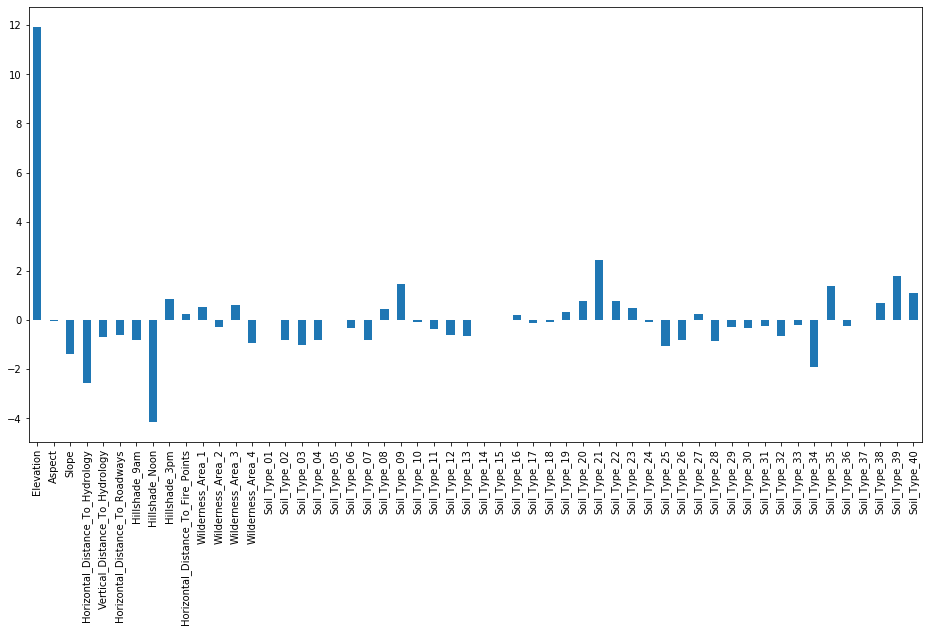

In [18]:
# show the coefficient value for each feature by a bar chart
def explain_logistic_regression(lr, feature_names):
    coefs = pd.Series(lr.coef_[0], index=feature_names)
    #coefs = coefs.sort_values()
    plt.subplot(1,1,1)
    coefs.plot(kind="bar")
    plt.show()
# explain the model
explain_logistic_regression(lr, feature_names)

For a specific prediction, we can get a more concrete effect of each feature by the product of the coefficient and input feature value. Please follow the comment to finish the code:

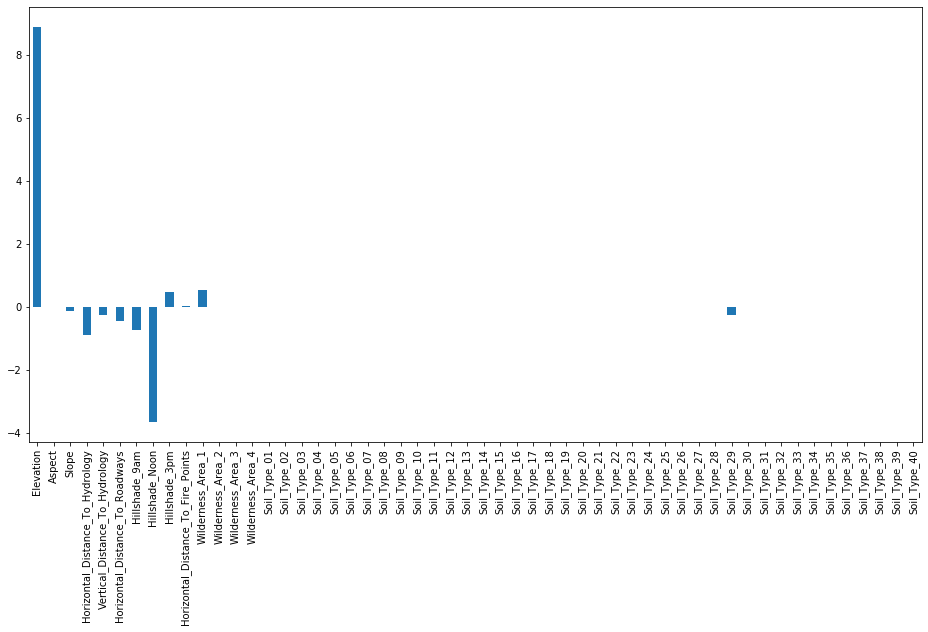

In [19]:
# show the effect from each input feature by a bar chart
def explain_logistic_regression_prediction(lr, feature_names, sample):
    product=lr.coef_[0]*sample[0]
    plt.subplot(1,1,1)
    product.plot(kind="bar")
    plt.show()
explain_logistic_regression_prediction(lr, feature_names, (X_test.iloc[0,:], y_test.iloc[0]))

What can you get from the above plots? Please write down two findings:

**Findings:**
1. Elevation is most positie effective to determine forrest cover type
2. Hillshade noon is most negitive effective to determine forrest cover type

## Task 2. Post-hoc Explanation (Global Model)

In this task, you are going to build a gradient boosting tree model and a neural network, and use some techniques we introduced in class to interpret these models. First, let's train the models using training data:

In [20]:
# train a gradient boosting classifier
gb = GradientBoostingClassifier().fit(X_train, y_train)

In [29]:
# train a multi-layer perceptron classifier
mlp = MLPClassifier(learning_rate_init=0.1).fit(X_train, y_train)

### 2.1 Permutation

In [26]:
from sklearn.utils import check_random_state
from sklearn.metrics import check_scoring
from joblib import Parallel
from joblib import delayed

#Calculate score when `col_idx` is permuted.
def _calculate_permutation_scores(estimator, X, y, col_idx, random_state,n_repeats, scorer):
    random_state = check_random_state(random_state)
    X_permuted = X.copy()
    scores = np.zeros(n_repeats)
    shuffling_idx = np.arange(X.shape[0])
    for n_round in range(n_repeats):
        random_state.shuffle(shuffling_idx)
        X_permuted[:, col_idx] = X_permuted[shuffling_idx, col_idx]
        feature_score = scorer(estimator, X_permuted, y)
        scores[n_round] = feature_score
    return scores

# get importance score (E' - E) for each feature by permutation, use log_loss as error
def permutation_importance(model, feature_names, X, y):
    # calculate importance score for each feature by purmutation approach
    n_repeats=5
    random_state=None
    n_jobs=None
    random_state = check_random_state(random_state)
    random_seed = random_state.randint(np.iinfo(np.int32).max + 1)

    scorer = check_scoring(model, scoring='neg_log_loss')
    baseline_score = scorer(model, X, y)

    scores = Parallel(n_jobs=n_jobs)(delayed(_calculate_permutation_scores)(
        model, X, y, col_idx, random_seed, n_repeats, scorer
    ) for col_idx in range(X.shape[1]))
    importances = baseline_score - np.array(scores)
    importances_mean=np.mean(importances, axis=1),
    # show the top 5 most important features
    important_features = pd.Series(importances_mean[0], index=X_train.columns)
    print(important_features.nlargest(5))
    
permutation_importance(gb, feature_names, X_test.to_numpy(), y_test.to_numpy())
permutation_importance(mlp, feature_names, X_test.to_numpy(), y_test.to_numpy())

Elevation                             0.373580
Horizontal_Distance_To_Roadways       0.033770
Horizontal_Distance_To_Hydrology      0.024157
Hillshade_Noon                        0.020441
Horizontal_Distance_To_Fire_Points    0.015432
dtype: float64
Elevation                           0.406267
Soil_Type_32                        0.050162
Horizontal_Distance_To_Roadways     0.043365
Hillshade_Noon                      0.024219
Horizontal_Distance_To_Hydrology    0.024063
dtype: float64


### 2.2 Partial dependence plots

In this section, you are going to use the [plot_partial_dependence](https://scikit-learn.org/stable/modules/generated/sklearn.inspection.plot_partial_dependence.html#sklearn.inspection.plot_partial_dependence) provided by sklearn to see the marginal effect of each single numerical features:

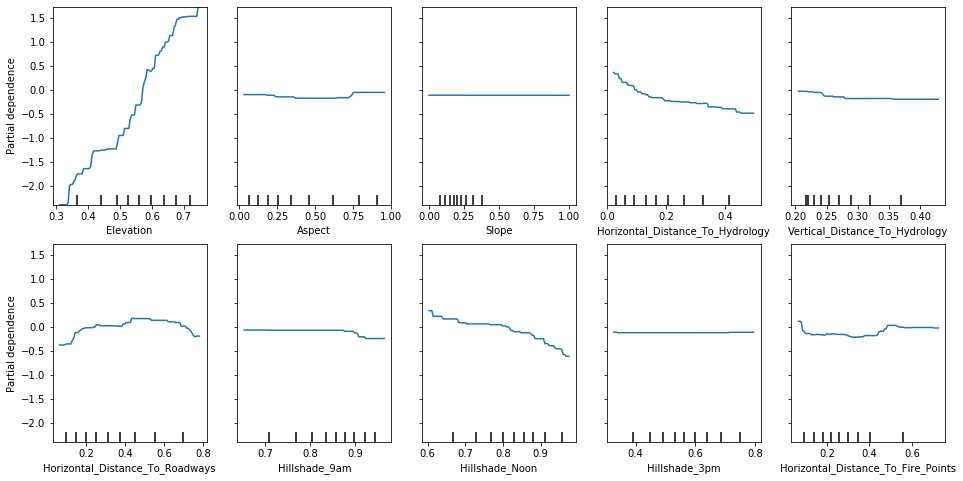

In [27]:
plot_partial_dependence(gb, X_train, feature_names[:10],n_cols=5)

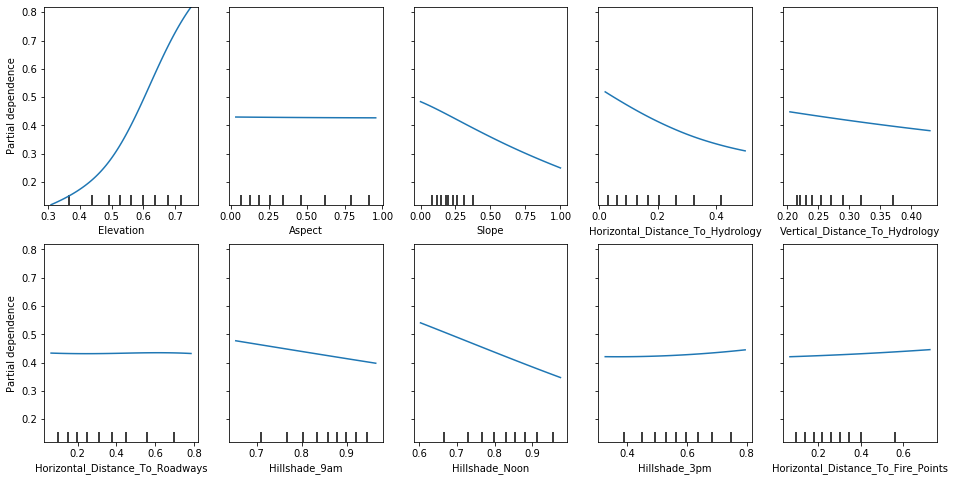

In [31]:
# plot partial dependence for numerical features (first 10 features) for neural network
plot_partial_dependence(mlp, X_train, feature_names[:10],n_cols=5)

### 2.3 Global Surrogate

Now, let's train a simple logistic regression based on the gradient boosting tree model and neural network we built before. And use the method we implemented previously to interpret the derived transparent model:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


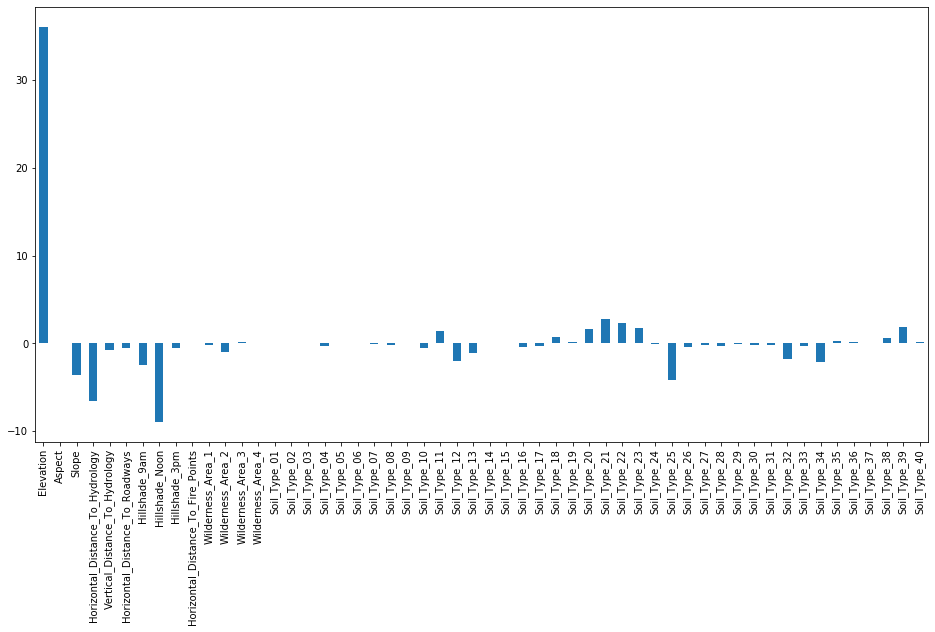

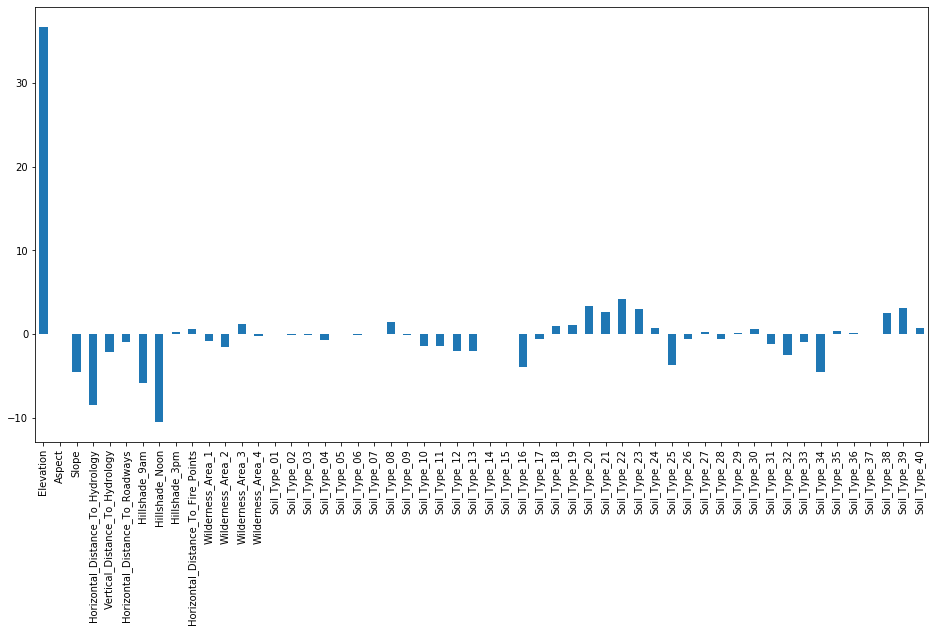

In [32]:
# train a logistic regression model on gb and mlp and explain using explain_logistic_regression()
y_gb=pd.Series(gb.predict(X_train))
y_mlp=pd.Series(mlp.predict(X_train))
lr_gb=LogisticRegression().fit(X_train,y=y_gb)
lr_mlp=LogisticRegression().fit(X_train,y=y_mlp)
explain_logistic_regression(lr_gb,feature_names)
explain_logistic_regression(lr_mlp,feature_names)

## Task 3. Post-hoc Explanation (Single Prediction)

### 3.1 Attribution

From now, let's focus on interpreting single predictions. [SHAP](https://github.com/slundberg/shap) is an efficient method to approximatly calculate the shapely value we mentioned in class. Please install the library and take a look at the doc. Explain the first prediction made by the gradient boosting tree model in the test set:

In [33]:
import shap

# load JS visualization code to notebook
shap.initjs()

# use Tree SHAP explainer to explain the gradient boosting tree model
# you only need to explain and plot the first explaination
explainer = shap.TreeExplainer(gb,X_train)
sample=shap.sample(X_test,1)
shap_values = explainer.shap_values(sample)
# plot the SHAP values for the Setosa output of the first instance
shap.force_plot(explainer.expected_value, shap_values,feature_names=feature_names)

Passing 39611 background samples may lead to slow runtimes. Consider using shap.sample(data, 100) to create a smaller background data set.


What can you get from the above representation? Please write down two findings:

**Findings:**
1.  The above explanation shows features each contributing to push the model output from the base value -0.4003(the average model output over the training dataset we passed) to the model output 0.86. 
2. Features pushing the prediction higher are shown in red(Elevation, Horizontal_Distance_ToHydrology,Hillshade_Noon,Horizontal_Distance_To_Fire_Points,etc), those pushing the prediction lower are in blue(Hillshade_Noon,Soil_Type_32,etc )


### 3.2 LIME

[LIME](https://github.com/marcotcr/lime) is a library implemented by the authors of the paper. Please install the library and take a look at the doc and tutorial. Use it to explain the first prediction made by the neural network model in the test set:

In [36]:
import lime
# use LimeTabularExplainer to explain the neural network model
# you only need to explain and plot the first explaination
np.random.seed(1)
explainer=lime.lime_tabular.LimeTabularExplainer(X_train.values,mode='classification',feature_names=feature_names,class_names=np.array([0,1]))
exp=explainer.explain_instance(X_test.values[0],mlp.predict_proba,num_features=5)
exp.show_in_notebook(show_table=True,show_all=False)

Run LIME multiple times, (Q1) what do you think of the stability of LIME? (Q2) Can you briefly explain the reason?

**Your Answer:** 
1. Not very stable
2. Because we want to be model-agnostic, what we can do to learn the behavior of the underlying model is to perturb the input and see how the predictions change. 

## Submission
Complete the code in this notebook, and submit it to the CourSys activity Assignment 7.